In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from numpy import mean
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
from sklearn.ensemble import VotingRegressor

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [7]:
# data reading
data = pd.read_csv('E:/aabc\myDeepTree\data-240321/gucTP.csv')
data = data.replace(-9999, float('nan'))
data.iloc[:, 0] = pd.to_numeric(data.iloc[:, 0], errors='coerce')
data = data.dropna()
data.columns = [
     'CCN','BS_B', 'BS_G', 'BS_R', 'AE_BG', 'AE_BR', 'AE_GR', 'BBS_B', 'BBS_G', 'BBS_R',
    'BSF_B', 'BSF_G', 'BSF_R', 'g_B', 'g_G', 'g_R', 'SSA_B', 'SSA_G', 'SSA_R', 
    'TR_B', 'TR_G', 'TR_R', 'RH', 'BA_B', 'BA_G', 'BA_R'
]
data

,CCN,BS_B,BS_G,BS_R,AE_BG,AE_BR,AE_GR,BBS_B,BBS_G,BBS_R,...,SSA_B,SSA_G,SSA_R,TR_B,TR_G,TR_R,RH,BA_B,BA_G,BA_R
5,550.952217,43.145440,33.368600,21.876892,1.959982,2.041535,2.109395,4.909241,4.420276,3.563093,...,0.987983,0.985023,0.980067,0.937652,0.946264,0.956325,35.836365,1.269633,1.096592,0.837468
6,560.005709,75.337860,57.593580,35.800575,2.048541,2.247578,2.413197,7.810824,6.944680,5.786875,...,1.002678,1.001679,0.996225,0.937478,0.946114,0.956201,36.100000,1.068737,0.901157,0.767810
9,567.910617,55.117252,43.960804,27.433380,1.725078,2.129572,2.466151,6.214628,4.835032,4.199146,...,0.996957,0.993185,0.981597,0.934336,0.943144,0.953586,32.750000,1.108316,1.064827,1.005721
10,606.038636,56.522476,44.164368,28.202677,1.881867,2.103782,2.288437,5.545890,4.923078,4.298800,...,1.013708,1.012138,1.009990,0.934230,0.943033,0.953479,32.358334,0.113473,0.170972,0.202542
17,544.077867,75.579510,57.887917,36.372140,2.034087,2.207130,2.351119,8.184023,6.635899,5.914550,...,1.020131,1.022576,1.026622,0.935593,0.944286,0.954500,35.416668,-0.357495,-0.402158,-0.410332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61915,195.423545,3.680213,2.841957,2.244977,1.971549,1.424857,0.969954,0.915781,0.540702,0.698998,...,0.679506,0.653280,0.654048,0.985214,0.987284,0.989629,12.950000,1.855158,1.602979,1.262073
61916,187.544351,4.238627,3.566895,2.670544,1.316087,1.390571,1.452550,0.818851,0.544277,0.699531,...,0.709268,0.700320,0.695836,0.984906,0.987016,0.989421,13.100000,1.858130,1.632458,1.249120
61917,184.844114,4.214589,3.455849,2.598696,1.513944,1.440298,1.379017,0.835356,0.660224,0.702542,...,0.709746,0.695051,0.690153,0.984625,0.986766,0.989230,12.916666,1.844844,1.620458,1.247090
61918,182.365281,3.653721,2.866382,2.119565,1.851169,1.605619,1.401296,0.654492,0.509239,0.406190,...,0.713932,0.693903,0.684290,0.984341,0.986520,0.989037,12.966666,1.570886,1.351806,1.044314


In [8]:
def remove_outliers(df):
    # Remove outliers using the 3-sigma rule
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        cutoff = std * 3
        lower = mean - cutoff
        upper = mean + cutoff
        df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# Apply function to remove outliers
data = remove_outliers(data)
data


,CCN,BS_B,BS_G,BS_R,AE_BG,AE_BR,AE_GR,BBS_B,BBS_G,BBS_R,...,SSA_B,SSA_G,SSA_R,TR_B,TR_G,TR_R,RH,BA_B,BA_G,BA_R
9,567.910617,55.117252,43.960804,27.433380,1.725078,2.129572,2.466151,6.214628,4.835032,4.199146,...,0.996957,0.993185,0.981597,0.934336,0.943144,0.953586,32.750000,1.108316,1.064827,1.005721
115,491.612221,63.674225,49.834415,31.511812,1.869311,2.132469,2.351442,7.076651,5.365071,4.464237,...,0.958183,0.952673,0.938560,0.940617,0.949528,0.960026,33.733334,3.934397,3.398772,2.668036
116,504.542269,67.234930,52.973976,32.136272,1.818345,2.253974,2.616462,6.625530,5.919486,4.691011,...,0.957728,0.952304,0.934589,0.940074,0.949049,0.959642,33.550000,4.186866,3.635862,2.871833
117,549.155239,77.575810,59.809303,37.609780,1.983881,2.188143,2.358109,7.647809,6.320363,5.286356,...,0.960888,0.955593,0.940851,0.939470,0.948525,0.959218,33.600000,4.562293,3.883175,3.084042
118,544.227930,73.364655,57.719060,35.774790,1.829503,2.186124,2.482868,7.477943,6.451732,5.311398,...,0.959849,0.955232,0.941418,0.938861,0.947994,0.958797,33.600000,4.394901,3.769745,2.910587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61663,118.828535,2.658496,2.136248,1.561916,1.668216,1.583843,1.513636,0.429092,0.424553,0.317157,...,0.954521,0.926627,0.929890,0.829919,0.855731,0.884562,11.033334,0.171758,0.206726,0.145937
61819,165.657559,2.625966,2.059236,1.480587,1.854360,1.700048,1.571646,0.521734,0.341327,0.341199,...,0.941813,0.889058,0.882290,0.992250,0.993156,0.994163,11.483334,0.212637,0.300879,0.229698
61839,153.672413,2.937862,2.363200,1.559320,1.660249,1.922883,2.141421,0.385938,0.356668,0.342058,...,0.945585,0.980836,0.981248,0.991314,0.992205,0.993474,11.400000,0.224794,0.088412,0.057921
61872,172.351058,2.778204,2.255061,1.840278,1.591319,1.193127,0.861793,0.263386,0.340004,0.327558,...,0.937994,0.903028,0.919131,0.989772,0.991138,0.992595,11.483334,0.237051,0.288567,0.198794


In [9]:
data = data[data['CCN'] >0]
data = data[data['SSA_B']<1]
data = data[data['SSA_G']<1]
data = data[data['SSA_R']<1]
data = data[data['BA_B']>0]
data = data[data['BA_G']>0]
data = data[data['BA_R']>0]
# data = data.loc[0:456806,:]# The first 200,000 groups of data in the sgp
# data = data.sample(n=200000, random_state=2024)
# Prepare features and target variable
X = data.drop('CCN', axis=1)  # Features
y = data['CCN']  # Features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

In [37]:


# 定义参数空间
xgb_params = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'random_state': Categorical([2024]),  # 设置随机种子
    # 'tree_method': Categorical(['gpu_hist'])  # 使用GPU
}



rf_params = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 16),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 6),
    'random_state': Categorical([2024])  # 设置随机种子
}


cb_params = {
    'iterations': Integer(50, 1000),
    'depth': Integer(3, 16),
    'learning_rate': Real(0.01, 0.4, prior='log-uniform'),
    'l2_leaf_reg': Real(0.05, 10, prior='log-uniform'),
    'random_state': Categorical([2024]),  # 设置随机种子
    # 'task_type': Categorical(['GPU']),  # 使用GPU
    # 'devices': Categorical(['0:1']),
    'train_dir': Categorical(["./catboost_info"])  # 日志目录
}

# 创建贝叶斯优化对象
opt_xgb = BayesSearchCV(XGBRegressor(), xgb_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)
opt_rf = BayesSearchCV(RandomForestRegressor(), rf_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)
opt_cb = BayesSearchCV(CatBoostRegressor(verbose=0), cb_params, n_iter=10, cv=5, n_jobs=-1, verbose=10)

# 执行搜索
opt_xgb.fit(X_train, y_train)
opt_rf.fit(X_train, y_train)
opt_cb.fit(X_train, y_train)

# 获取最佳参数
print("Best XGBoost params:", opt_xgb.best_params_)
print("Best RF params:", opt_rf.best_params_)
print("Best CatBoost params:", opt_cb.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

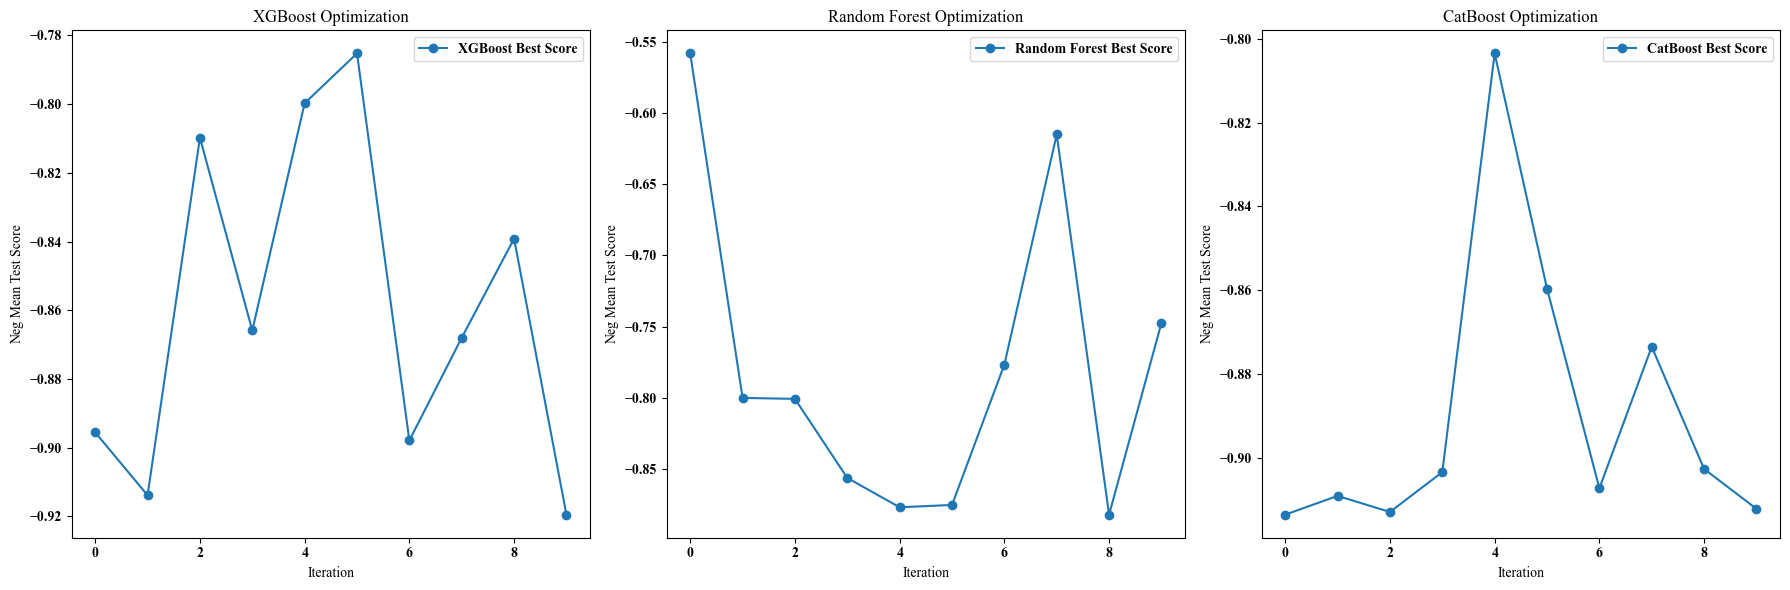

Mean Squared Error: 917.8576412415584


In [38]:
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Plot Bayesian optimization process
def plot_optimization_results(opt, model_name):
    results = opt.cv_results_
    best_scores = -np.array(results['mean_test_score'])
    plt.plot(best_scores, marker='o', label=f'{model_name} Best Score')
    plt.xlabel('Iteration')
    plt.ylabel('Neg Mean Test Score')
    plt.title(f'{model_name} Optimization')
    plt.legend()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_optimization_results(opt_xgb, "XGBoost")
plt.subplot(1, 3, 2)
plot_optimization_results(opt_rf, "Random Forest")
plt.subplot(1, 3, 3)
plot_optimization_results(opt_cb, "CatBoost")
plt.tight_layout()
plt.show()

# Create models with best parameters
xgb_best = XGBRegressor(**opt_xgb.best_params_, n_jobs=-1)
rf_best = RandomForestRegressor(**opt_rf.best_params_, n_jobs=-1)
cb_best = CatBoostRegressor(**opt_cb.best_params_, verbose=0)

# Create ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('xgb', xgb_best),
    ('rf', rf_best),
    ('cb', cb_best)
])

# Train ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
predictions = ensemble_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


In [39]:
np.save('E:/aabc/myDeepTree/data-240520/guc1xgb.npy', opt_xgb.best_params_)
np.save('E:/aabc/myDeepTree/data-240520/guc1rf.npy', opt_rf.best_params_)
np.save('E:/aabc/myDeepTree/data-240520/guc1cb.npy',opt_cb.best_params_)

In [10]:
opt_xgb_best_params = np.load('E:/aabc/myDeepTree/data-240520/guc1xgb.npy', allow_pickle=True).item()
opt_rf_best_params = np.load('E:/aabc/myDeepTree/data-240520/guc1rf.npy', allow_pickle=True).item()
opt_cb_best_params = np.load('E:/aabc/myDeepTree/data-240520/guc1cb.npy', allow_pickle=True).item()
print(opt_xgb_best_params,opt_rf_best_params,opt_cb_best_params)

OrderedDict([('colsample_bytree', 0.5514033014577041), ('learning_rate', 0.08327906191340359), ('max_depth', 10), ('n_estimators', 928), ('random_state', 2024), ('subsample', 0.96564380448735)]) OrderedDict([('max_depth', 15), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 792), ('random_state', 2024)]) OrderedDict([('depth', 15), ('iterations', 587), ('l2_leaf_reg', 8.474172600753876), ('learning_rate', 0.15074646132379058), ('random_state', 2024), ('train_dir', './catboost_info')])


In [11]:
# Use optimal parameters
xgb_best = XGBRegressor(**opt_xgb_best_params, n_jobs=-1)
rf_best = RandomForestRegressor(**opt_rf_best_params, n_jobs=-1)
# xgb_best = XGBRegressor(**opt_xgb_best_params)
# rf_best = RandomForestRegressor(**opt_rf_best_params)
cb_best = CatBoostRegressor(**opt_cb_best_params, verbose=0)

# Create an integration model
ensemble_model = VotingRegressor(estimators=[
    ('xgb', xgb_best),
    ('rf', rf_best),
    ('cb', cb_best)
])

ensemble_model.fit(X_train, y_train)

predictions = ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 917.8576412415584


In [18]:

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


def density_scatter(x, y, ax=None, is_cbar=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, cmap='Spectral_r')

    if is_cbar:
        norm = Normalize(vmin=np.min(z), vmax=np.max(z))
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='Spectral_r'), ax=ax)
        cbar.ax.tick_params(labelsize=10)  
        cbar.ax.set_yticklabels(['{:.1e}'.format(t) for t in cbar.get_ticks()], fontname='Times New Roman') 

    return ax


x = y_test_guc.to_numpy()
y = predictions_guc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

density_scatter(x=x, y=y, ax=ax, is_cbar=True)

slope, intercept, r_value, p_value, std_err = linregress(x, y)

regression_line = slope * x + intercept
plt.plot(x, regression_line, 'red', lw=2, label='线性回归线')

plt.plot([0, 800], [0, 800], 'black', lw=1.5, linestyle='--')  # 1:1
plt.axis([0, 800, 0, 800])

ax.tick_params(axis='both', labelsize=14)

ax.set_xticklabels(ax.get_xticks(), size=14)
ax.set_yticklabels(ax.get_yticks(), size=14)

BIAS_guc = mean(x - y)
MSE_guc = mean_squared_error(x, y)
RMSE_guc = np.power(MSE_guc, 0.5)
R2_guc = r2_score(x, y)
MAE_guc = mean_absolute_error(x, y)
EV_guc = explained_variance_score(x, y)

text = f'\nMAE: {MAE_guc:.3f}\nRMSE: {RMSE_guc:.3f}\nR²: {R2_guc:.3f}'
plt.yticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xticks(fontsize=10, fontname='Times New Roman', fontweight='bold')
plt.xlabel(r'[CCN0.4]_True$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.ylabel(r'[CCN0.4]_Predict$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('(c)', loc='left', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('GUC', fontsize=16, fontname='Times New Roman', fontweight='bold')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.text(50,650, text, fontsize=14, fontname='Times New Roman')
plt.savefig('E:/aabc/summary/fig-240804/guc.png',dpi=300,bbox_inches='tight',pad_inches=0)

plt.show()


NameError: name 'y_test_guc' is not defined

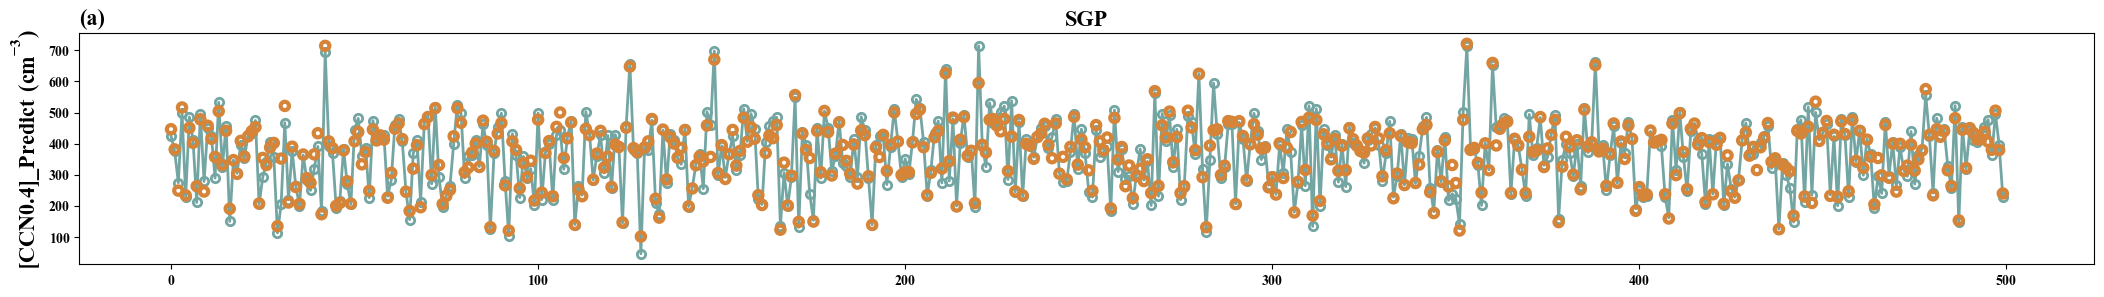

In [41]:
# 绘制折线图
plt.figure(figsize=(26, 3))

plt.scatter(range(len(predictions))[0:500], predictions[0:500], label='Predicted Values', marker='o', color='#d68438', s=36, facecolors='none', edgecolors='#d68438', linewidths=3, zorder=2)
plt.plot(range(len(y_test))[0:500], y_test[0:500],color='#73a5a2', label='True Values', marker='o', linestyle='-', markersize=6, markerfacecolor='none', markeredgewidth=2,linewidth=2, zorder=1)
plt.title('SGP', fontsize=16, fontname='Times New Roman', fontweight='bold')
plt.title('(a)', loc='left', fontsize=16, fontname='Times New Roman', fontweight='bold')
# plt.xlabel('Sample Index')
plt.ylabel(r'[CCN0.4]_Predict$\mathregular{\ (cm^{-3})}$', fontsize=16, fontname='Times New Roman', fontweight='bold')
# plt.legend()
# plt.grid(True)
# plt.savefig('E:/aabc/summary/fig-240727/sgp-line2.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

In [15]:
# SHAP interactions are based on the xgboost model
xgb_model = XGBRegressor(**opt_xgb_best_params, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

In [16]:
# Randomly select 3000 samples for SHAP analysis
np.random.seed(2024)
indices = np.random.choice(X_test.shape[0], 3000, replace=False)
# selected_X_test = X_test  # Comment this out if using the random subset
selected_X_test = X_test.iloc[indices]
# Create an explainer
explainer = shap.TreeExplainer(xgb_model)
# Compute SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(selected_X_test)


In [17]:
# shap
explainer = shap.KernelExplainer(ensemble_model.predict, data=X_train.sample(100))
shap_values = explainer.shap_values(X_test.iloc[indices])


X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 0/3000 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 1/3000 [00:03<3:09:05,  3.78s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 2/3000 [00:07<3:05:19,  3.71s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  0%|          | 3/3000 [00:11<3:03:30,  3.67s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was

In [21]:
shap_values_guc=shap_values
selected_X_test_guc=selected_X_test
shap_interaction_values_guc=shap_interaction_values


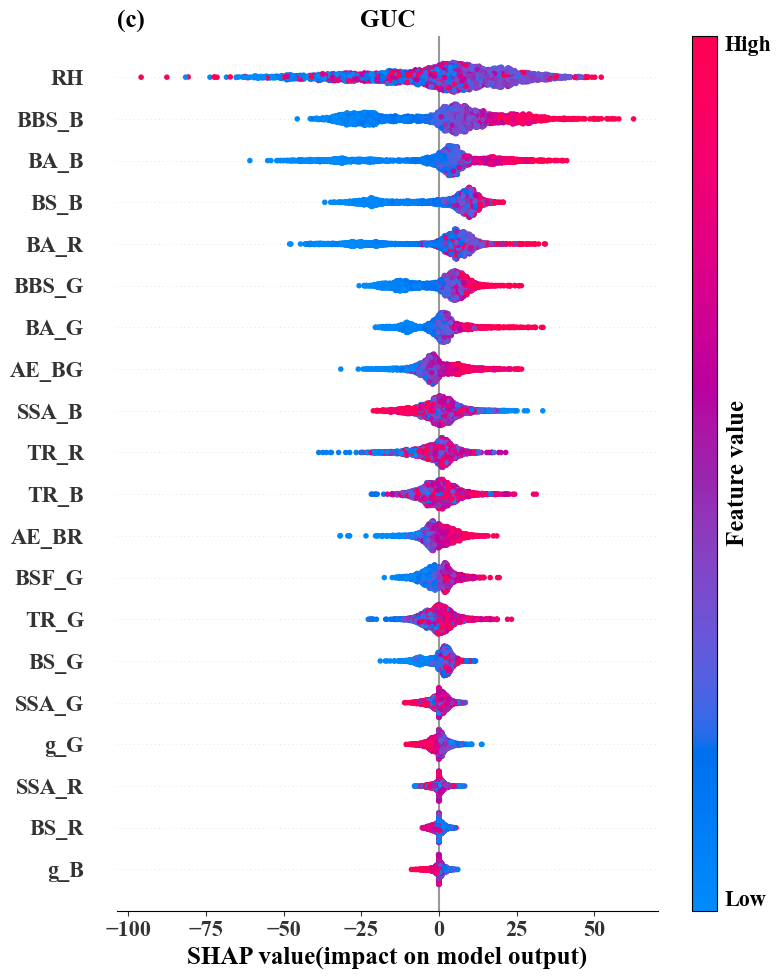

In [22]:
# summary
import os
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

shap.summary_plot(shap_values_guc, selected_X_test_guc, show=False,color_bar=False)
cbar = plt.colorbar(aspect=35)
cbar.set_label('Feature value',size=18,fontname='Times New Roman', fontweight='bold')
cbar.ax.set_yticklabels([])
cbar.ax.tick_params(axis='y', which='both', length=0)
cbar.ax.text(1.3,0,'Low',va='bottom',ha='left',transform=cbar.ax.transAxes,fontsize=16)
cbar.ax.text(1.3,1,'High',va='top',ha='left',transform=cbar.ax.transAxes,fontsize=16)

plt.xlabel('SHAP value(impact on model output)',fontsize=18,fontname='Times New Roman', fontweight='bold')
plt.tick_params(axis='x',labelsize=16)
plt.tick_params(axis='y',labelsize=16)
plt.title('(c)', loc='left', fontsize=18, fontname='Times New Roman', fontweight='bold')
plt.title('GUC', fontsize=18, fontname='Times New Roman', fontweight='bold')
plt.savefig('E:/aabc/summary/fig-240804/shap-guc.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


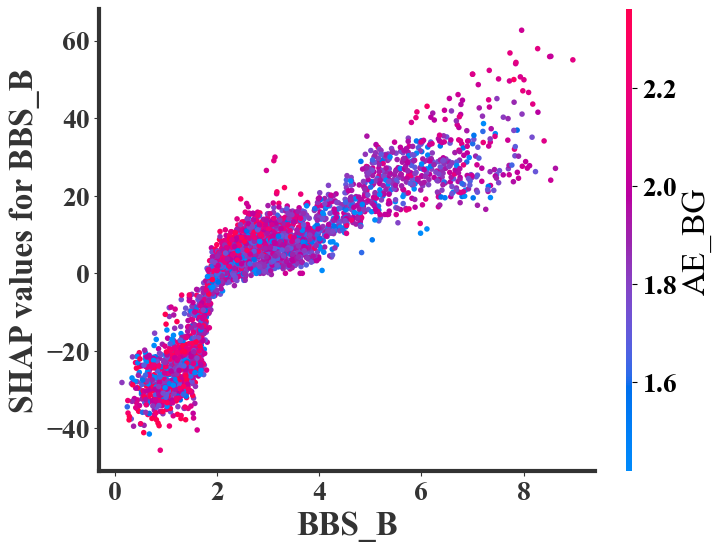

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values_guc, selected_X_test_guc, interaction_index='AE_BG', ax=ax, show=False)
# dependence

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
cbar.set_label('AE_BG', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('E:/aabc/summary/fig-240804/guc11.png',dpi=300,bbox_inches='tight',pad_inches=0)

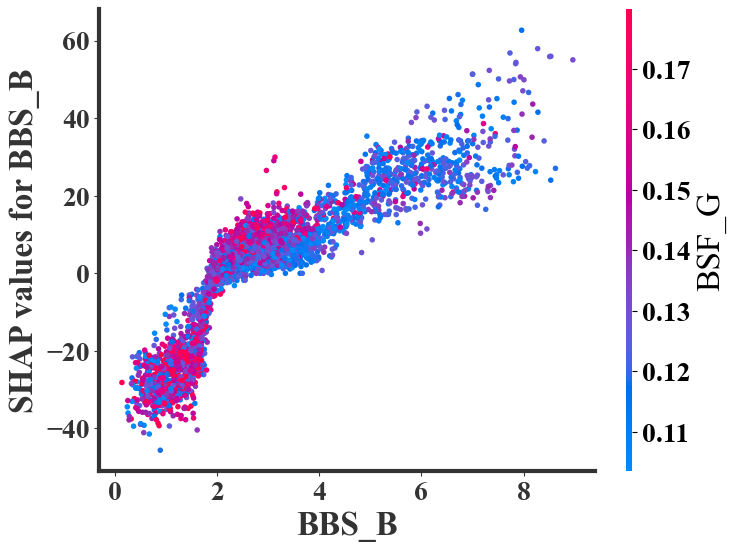

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values_guc, selected_X_test_guc, interaction_index='BSF_G', ax=ax, show=False)
# dependence

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
cbar.set_label('BSF_G', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('E:/aabc/summary/fig-240804/guc1.png',dpi=300,bbox_inches='tight',pad_inches=0)

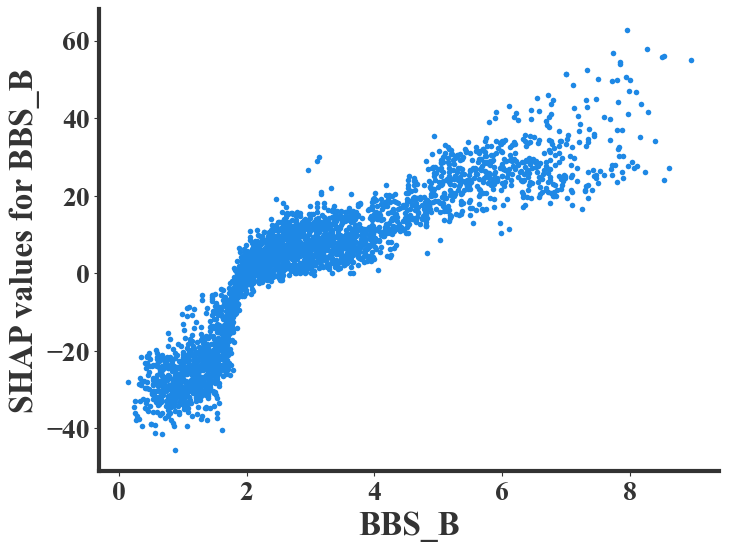

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.dependence_plot('BBS_B', shap_values_guc, selected_X_test_guc, interaction_index=None, ax=ax, show=False)
# dependence

# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
# cbar.set_label('AE_BG', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('E:/aabc/summary/fig-240804/guc2.png',dpi=300,bbox_inches='tight',pad_inches=0)

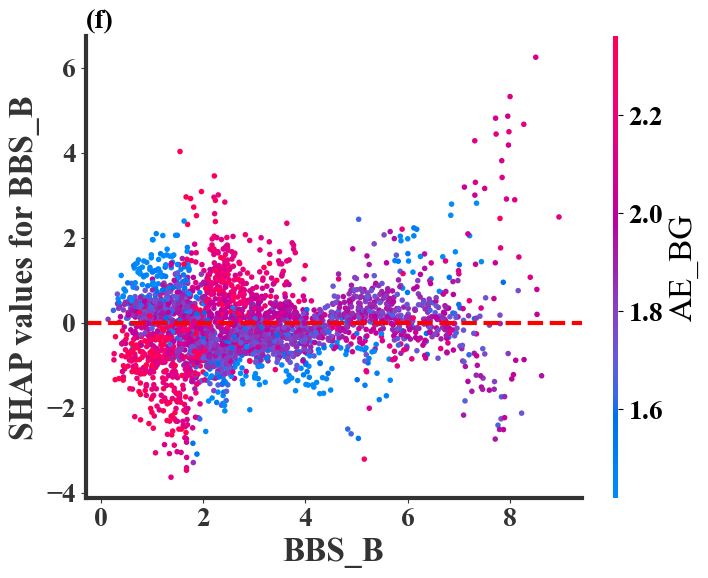

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BBS_B",  # key feature
    shap_interaction_values_guc[:, :, selected_X_test_guc.columns.get_loc("AE_BG")],  
    selected_X_test_guc,
    interaction_index="AE_BG",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
cbar.set_label('AE_BG', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_title('(f)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
plt.savefig('E:/aabc/summary/fig-240804/guc33t.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


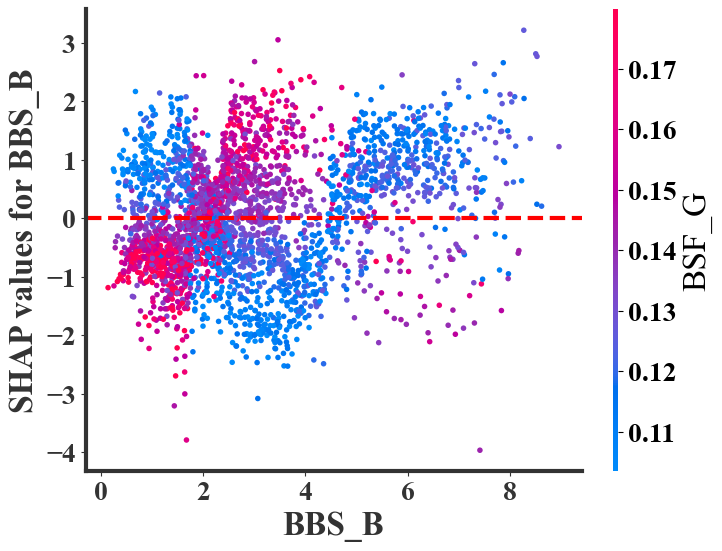

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
# interaction
shap.dependence_plot(
    "BBS_B",  # key feature
    shap_interaction_values_guc[:, :, selected_X_test_guc.columns.get_loc("BSF_G")],  
    selected_X_test_guc,
    interaction_index="BSF_G",  # interactive feature
    ax=ax,
    show=False
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20) # 设置标签字体大小
cbar.set_label('BSF_G', fontsize=24) # 设置标签大小
ax.set_xlabel('BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.set_ylabel('SHAP values for BBS_B', fontsize=24, fontname='Times New Roman', fontweight='bold')
ax.spines['bottom'].set_linewidth(3)  
ax.spines['top'].set_linewidth(3)  
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.set_title('(e)', loc='left', fontsize=20, fontname='Times New Roman', fontweight='bold')
ax.axhline(0, color='red', linestyle='--', linewidth=3)
plt.savefig('E:/aabc/summary/fig-240804/guc3t.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()


In [31]:
# save
shap_values_df_guc = pd.DataFrame(shap_values_guc, columns=X_train.columns)

shap_values_df_guc
shap_values_df_guc.to_csv('E:/aabc\myDeepTree\data-240806/gucshap_values.csv', index=False)

feature_importance_guc = np.abs(shap_values_df_guc).mean().sort_values(ascending=False)
feature_importance_guc.to_csv('E:/aabc\myDeepTree\data-240806/gucfeature_importance.csv')
total_shap_guc = feature_importance_guc.sum()

# contribution_ratio
feature_contribution_ratio_guc = (feature_importance_guc / total_shap_guc) * 100

feature_contribution_ratio_guc.to_csv('E:/aabc\myDeepTree\data-240806/gucfeature_contribution_ratio.csv')
feature_contribution_ratio_guc

RH       13.819050
BBS_B    12.734612
BA_B      9.641604
BS_B      8.935640
BA_R      8.428134
BBS_G     6.154414
BA_G      4.054266
AE_BG     3.989699
SSA_B     3.819876
TR_R      3.650744
TR_B      3.371381
AE_BR     2.966511
BSF_G     2.853095
TR_G      2.842146
BS_G      2.623911
SSA_G     1.729403
g_G       1.679125
SSA_R     1.054232
BS_R      1.050144
g_B       0.991884
BBS_R     0.946404
BSF_B     0.788437
BSF_R     0.733243
AE_GR     0.729044
g_R       0.413000
dtype: float64